Copyright (c) 2020-2021 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# AutoVW: ChaCha for Online AutoML with Vowpal Wabbit


## 1. Introduction


In this notebook, we use one real data example (regression task) to showcase AutoVW, which is an online AutoML solution based on the following work:

*ChaCha for online AutoML. Qingyun Wu, Chi Wang, John Langford, Paul Mineiro and Marco Ross. To appear at ICML 2021.*

AutoVW is implemented in FLAML. FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
!pip install flaml[notebook];

## 2. Online Regression with AutoVW
### Load data from openml and preprocess

Download [dataset_sales](https://www.openml.org/d/42183) from OpenML.

In [1]:
import openml
# did = 42183
did = 41506
ds = openml.datasets.get_dataset(did)
target_attribute = ds.default_target_attribute
data = ds.get_data(target=target_attribute, dataset_format='array')
X, y = data[0], data[1]  # return X: pd DataFrame, y: pd series
print(X.shape, y.shape)

(36203, 17) (36203,)


Convert the openml dataset into vowpalwabbit examples:
Sequentially group features into up to namespaces and convert the original data examples into vowpal wabbit format.

In [12]:
import numpy as np
import string
NS_LIST = list(string.ascii_lowercase) + list(string.ascii_uppercase)
max_ns_num = 10 # the maximum number of namespaces
max_size_per_group = int(np.ceil(X.shape[1] / float(max_ns_num)))
# sequential grouping
group_indexes = []
for i in range(max_ns_num):
    indexes = [ind for ind in range(i * max_size_per_group,
                min((i + 1) * max_size_per_group, orginal_dim))]
    if len(indexes) > 0:
        group_indexes.append(indexes)

vw_examples = []
for i in range(X.shape[0]):
    ns_content = []
    for zz in range(len(group_indexes)):
        ns_features = ' '.join('{}:{:.6f}'.format(ind, X[i][ind]) for ind in group_indexes[zz])
        ns_content.append(ns_features)
    ns_line = '{} |{}'.format(str(y[i]), '|'.join('{} {}'.format(NS_LIST[j], ns_content[j]) for j in range(len(group_indexes))))
    vw_examples.append(ns_line)
print('openml example:', y[0], X[0])
print('vw example:', vw_examples[0])

openml example: 8.170000076293945 [1.0000e+01 7.0000e+00 3.0000e+00 4.0000e+00        nan 6.3300e+00
 1.3600e-01 7.3300e+00 7.0100e+00 6.9800e+00 3.0000e-03 7.0000e+00
 9.7000e+00 1.2300e+01 1.0217e+03 0.0000e+00 5.8000e+01]
vw example: 8.170000076293945 |a 0:10.000000 1:7.000000|b 2:3.000000 3:4.000000|c 4:nan 5:6.330000|d 6:0.136000 7:7.330000|e 8:7.010000 9:6.980000|f 10:0.003000 11:7.000000|g 12:9.700000 13:12.300000|h 14:1021.700012 15:0.000000|i 16:58.000000


### Construct Vowpal Wabbit(VW) and AutoVW learners


In [32]:
''' import AutoVW class from flaml package '''
from flaml import AutoVW
from vowpalwabbit import pyvw
from flaml.tune import polynomial_expansion_set, loguniform
# set up the fixed hyperparameters in vw
fixed_hp_config = {'alg': 'supervised', 'loss_function': 'squared'}

''' create a vanilla vw instance '''
vanilla_vw = pyvw.vw(**fixed_hp_config)

''' set up the init config and search space and create an AutoVW instance'''
# tuning namespace interactions
init_config = fixed_hp_config.copy()
search_space = fixed_hp_config.copy()

namespace_feature_dim = AutoVW.get_ns_feature_dim_from_vw_example(vw_examples[0])
raw_namespaces = list(namespace_feature_dim.keys())

init_config.update({'interactions': set()})
search_space.update({'interactions': polynomial_expansion_set(init_monomials=set(raw_namespaces),highest_poly_order=len(raw_namespaces),allow_self_inter=False),
                     })
autovw = AutoVW(init_config=init_config,
                search_space=search_space,
                max_live_model_num=5,
                min_resource_lease='auto',
                random_seed=2345)

''' create another AutoVW instance with a different search space'''
# tuning both namespace interactions and learning rate
init_config_nslr = fixed_hp_config.copy()
search_space_nslr = fixed_hp_config.copy()
init_config_nslr.update({'interactions': set(), 'learning_rate': 0.5})
search_space_nslr.update({'interactions': polynomial_expansion_set(init_monomials=set(raw_namespaces),highest_poly_order=len(raw_namespaces),allow_self_inter=False),
'learning_rate': loguniform(lower=2e-10, upper=1.0),
                     })
autovw_nslr = AutoVW(init_config=init_config_nslr,
                search_space=search_space_nslr,
                max_live_model_num=5,
                min_resource_lease='auto',
                random_seed=2345)


Created challengers from champion |supervised||squared
New challenger size 37, ['|supervised|fg|squared', '|supervised|df|squared', '|supervised|bc|squared', '|supervised|dg|squared', '|supervised|ei|squared', '|supervised|be|squared', '|supervised|ah|squared', '|supervised|bf|squared', '|supervised|gh|squared', '|supervised|ac|squared', '|supervised|gi|squared', '|supervised|ci|squared', '|supervised|bd|squared', '|supervised|de|squared', '|supervised|cg|squared', '|supervised|cd|squared', '|supervised|af|squared', '|supervised|dh|squared', '|supervised|ae|squared', '|supervised|ag|squared', '|supervised|ch|squared', '|supervised|bi|squared', '|supervised|eh|squared', '|supervised|di|squared', '|supervised|eg|squared', '|supervised|ab|squared', '|supervised|ef|squared', '|supervised|fh|squared', '|supervised|ad|squared', '|supervised|bh|squared', '|supervised|cf|squared', '|supervised|bg|squared', '|supervised|hi|squared', '|supervised|fi|squared', '|supervised|ai|squared', '|supervis

### Online learning with VW and AutoVW 

In [33]:
from sklearn.metrics import mean_squared_error
def online_learning_loop(iter_num, vw_examples, vw_alg):
    """Implements the online learning loop.
    """
    print('Online learning on', iter_num, ' steps...')
    loss_list = []
    y_predict_list = []
    for i in range(iter_num):
        vw_x = vw_examples[i]
        y_true = float(vw_examples[i].split('|')[0])
        # predict step
        y_pred = vw_alg.predict(vw_x)
        # learn step
        vw_alg.learn(vw_x)
        # calculate one step loss
        loss = mean_squared_error([y_pred], [y_true])
        loss_list.append(loss)
        y_predict_list.append([y_pred, y_true])
    return loss_list

max_iter_num = 10000  # or len(vw_examples)
loss_list_vanilla = online_learning_loop(max_iter_num, vw_examples, vanilla_vw)
print('average final loss of vanilla vw:', sum(loss_list_vanilla)/len(loss_list_vanilla))

loss_list_autovw_ni = online_learning_loop(max_iter_num, vw_examples, autovw)
print('average final loss of autovw:', sum(loss_list_autovw_ni)/len(loss_list_autovw_ni))

loss_list_autovw_nilr = online_learning_loop(max_iter_num, vw_examples, autovw_nslr)
print('average final loss of autovw_nslr:', sum(loss_list_autovw_nilr)/len(loss_list_autovw_nilr))


rerunning exp.... 36203 10000
average final loss of vanilla vw: 15.180878192648041
rerunning exp.... 36203 10000
Created challengers from champion |supervised|ce|squared
New challenger size 43, ['|supervised|ce_ef|squared', '|supervised|ce_ci|squared', '|supervised|ad_ce|squared', '|supervised|ce_cei|squared', '|supervised|be_ce|squared', '|supervised|ce_cf|squared', '|supervised|ce_gi|squared', '|supervised|cd_ce|squared', '|supervised|ace_ce|squared', '|supervised|ag_ce|squared', '|supervised|ce_ch|squared', '|supervised|bce_ce|squared', '|supervised|bf_ce|squared', '|supervised|ce_eg|squared', '|supervised|ce_cg|squared', '|supervised|ce_eh|squared', '|supervised|ce_fg|squared', '|supervised|ce_dh|squared', '|supervised|ab_ce|squared', '|supervised|bh_ce|squared', '|supervised|ce_fh|squared', '|supervised|ce_cef|squared', '|supervised|ce_hi|squared', '|supervised|ce_di|squared', '|supervised|bi_ce|squared', '|supervised|ce|squared', '|supervised|cde_ce|squared', '|supervised|af_ce|s

### Plot progressive validation loss 

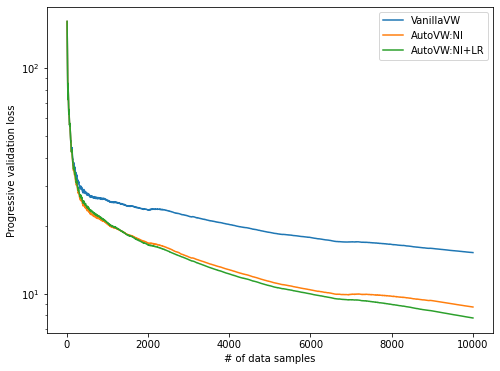

In [34]:
import matplotlib.pyplot as plt
def plot_progressive_loss(obj_list, alias, result_interval=1,):
    """Show real-time progressive validation loss
    """
    avg_list = [sum(obj_list[:i]) / i for i in range(1, len(obj_list))]
    total_obs = len(avg_list)
    warm_starting_point = 10 #0
    plt.plot(range(warm_starting_point, len(avg_list)), avg_list[warm_starting_point:], label = alias)
    plt.xlabel('# of data samples',)
    plt.ylabel('Progressive validation loss')
    plt.yscale('log')
    plt.legend(loc='upper right')
plt.figure(figsize=(8, 6))
plot_progressive_loss(loss_list_vanilla, 'VanillaVW')
plot_progressive_loss(loss_list_autovw_ni, 'AutoVW:NI')
plot_progressive_loss(loss_list_autovw_nilr, 'AutoVW:NI+LR')
plt.show()